In [1]:
from astropy.io import fits
import pylab
import itertools
from astropy.stats import mad_std, bootstrap
import numpy

In [2]:
fh = fits.open("TRCS00049040.fits")

In [3]:
fh[0].header

SIMPLE  =                    T / FITS standard                                  
BITPIX  =                   16 / bit per pixel                                  
NAXIS   =                    3 / number of axes                                 
NAXIS1  =                 2220 / size of the axis1                              
NAXIS2  =                 1360 / size of the axis2                              
NAXIS3  =                   10 / size of the axis3                              
EXTEND  =                    F                                                  
BZERO   =                 8192 / data zero                                      
BSCALE  =                 0.25 / data scale                                     
COMMENT ------------- OBSERVATION SECTION                                       
DATE-OBS= '2021-10-26'         / Observation start date (yyyy-mm-dd)            
JST-STR = '19:04:56.20'        / JST at exposure start (HH:MM:SS.SS)            
JST-END = '19:09:56.20'     

とりあえず最初の二つのデータプレーンを見てみる

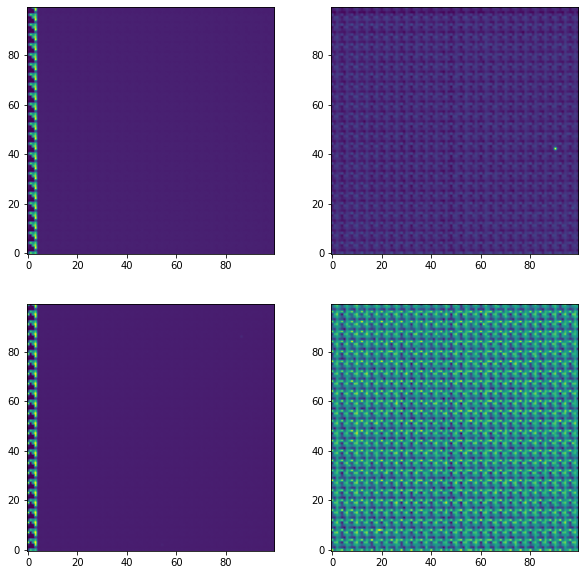

In [4]:
figs, axs = pylab.subplots(2, 2, figsize=(10,10))
img = fh[0].data[0].astype(numpy.float64)

for ax, reg in zip(axs.flatten(), 
        [ img[-100:,0:100], img[-100:,-100:], img[0:100,0:100], img[0:100,-100:] ]
       ):
    ax.imshow(reg,origin="lower")

この左端っ子のやつはなんだろう

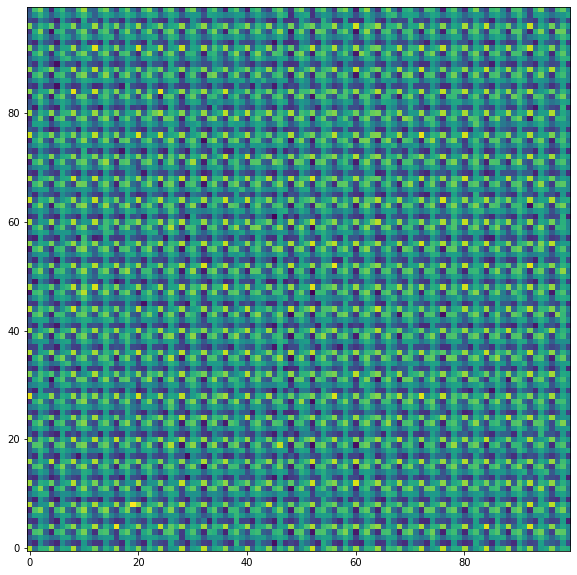

In [5]:
fig = pylab.figure(figsize=(10,10))
img = fh[0].data[0].astype(numpy.float64)
pylab.imshow(img[0:100,-100:],origin="lower")

4x4 のパターンで読み出しているそうなので，i,j 方向にそれぞれ 4 pixel ずつ飛ばしながらよんで表示する

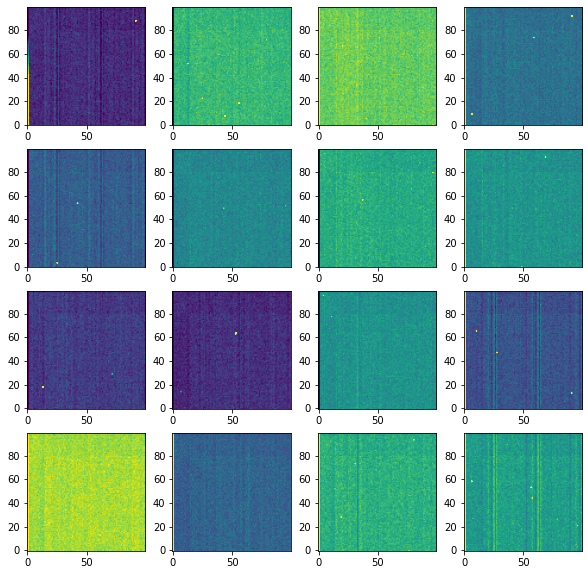

In [6]:
figs, axs = pylab.subplots(4, 4, figsize=(10,10))
#nedge=4
s = mad_std(img)
m = numpy.mean(img)
for i, j in  list(itertools.product( range(4), repeat=2 )):
#    subregion = img[i+nedge:-nedge:4,j+nedge:-nedge:4]
    subregion = img[i::4,j::4][-100:,:100]
#    axs[i][j].imshow( subregion[0:50,0:50], vmin=std*-3,vmax=std*3)
#    s=mad_std(subregion.flatten())
#    m=numpy.mean(subregion.flatten())
    axs[3-i][j].imshow( subregion, vmin=s*-2+m,vmax=s*2+m, origin="lower")

なんか変な縦の筋がある．

引き算をしてみる．

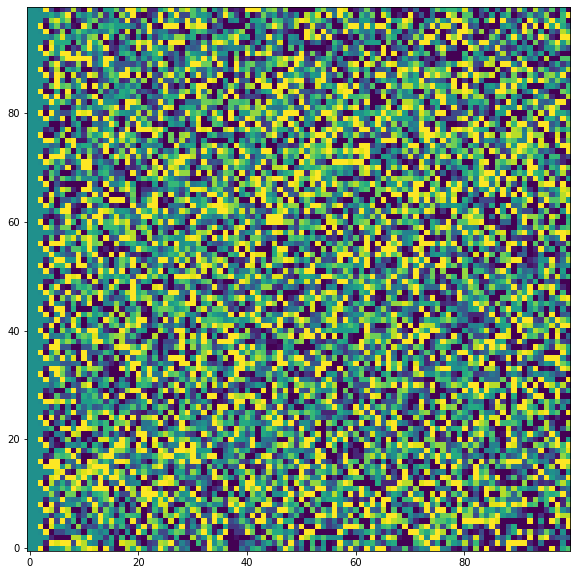

In [7]:
fig = pylab.figure(figsize=(10,10))
diff = fh[0].data[0].astype(numpy.float64) - fh[0].data[1].astype(numpy.float64)
std = mad_std(diff)
pylab.imshow(diff[0:100,0:100],vmin=std*-1,vmax=std*1,origin="lower")

4x4 ちゃんねるバラバラにしてみる

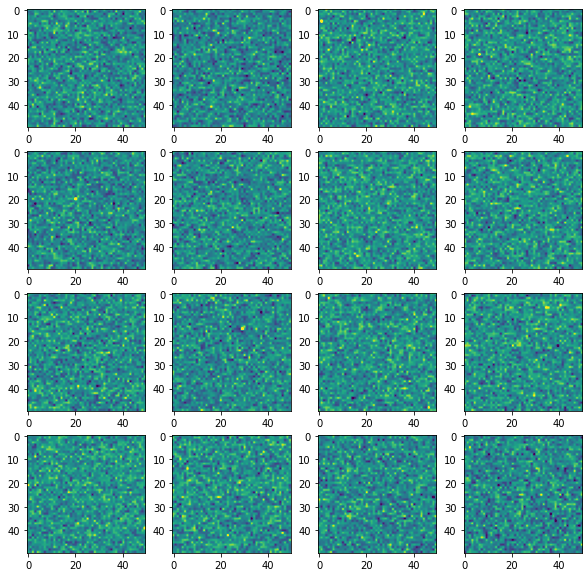

In [8]:
figs, axs = pylab.subplots(4, 4, figsize=(10,10))
nedge=100
for i, j in  list(itertools.product( range(4), repeat=2 )):
    subregion = diff[i+nedge:-nedge:4,j+nedge:-nedge:4]
    axs[3-i][j].imshow( subregion[0:50,0:50], vmin=std*-3,vmax=std*3)


引き算すると縦筋は消えた．どこいったん？

ヒストグラムを見てみる

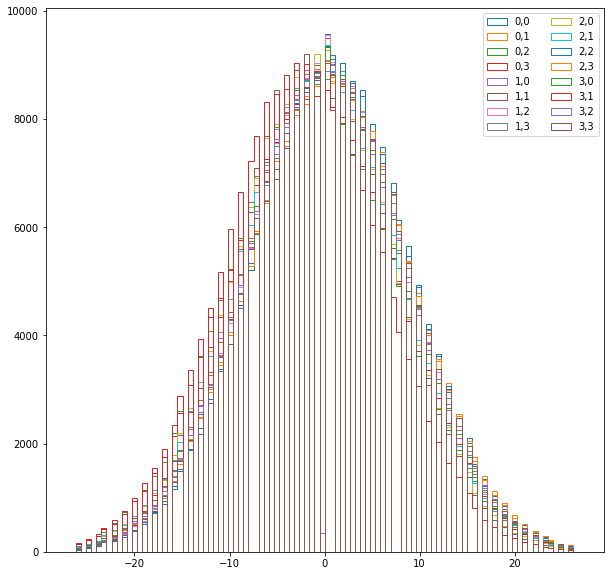

In [9]:
fig = pylab.figure(figsize=(10,10))
for i, j in ( list(itertools.product( range(4), repeat=2 )) ):
    pylab.hist(diff[i::4,j::4].flatten(), range=(std*-3,std*3), bins=100, label=f"{i},{j}", histtype="step")
pylab.legend(ncol=2)

- offset がある
- 整数と整数の引き算だから離散化しているのか

Text(0.5, 0, 'Amplifier')

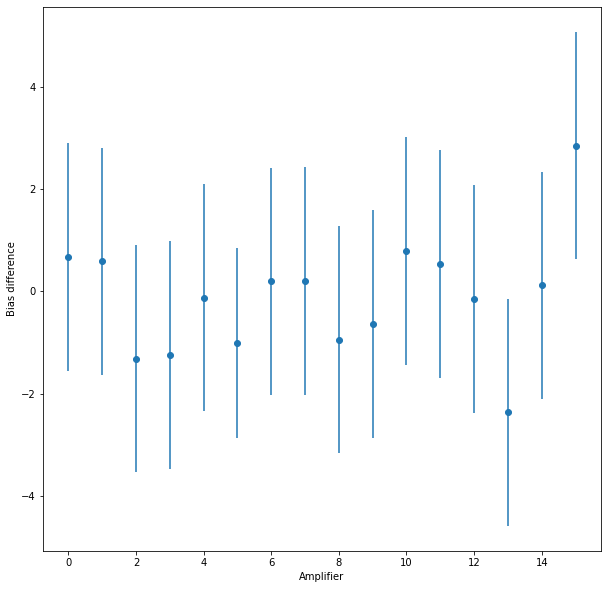

In [10]:
fig = pylab.figure(figsize=(10,10))
nedge=4
meanarr=[]
stdarr=[]
for i, j in ( list(itertools.product( range(4), repeat=2 )) ):
    meanarr.append( diff[i::4,j::4].flatten().mean() )
    stdarr.append( mad_std(diff[i::4,j::4].flatten()) )

pylab.errorbar( x=numpy.arange(len(meanarr)),  y=meanarr, yerr=stdarr/numpy.sqrt(len(meanarr)), fmt="o" )
pylab.ylabel("Bias difference")
pylab.xlabel("Amplifier")

bias が a few ADU のレベルで揺れているかもしれない

[8.28184581302385, 8.642316432802017, 8.968263864393203, 8.8785877009744, 8.731704402747747, 8.189358611936198, 8.29407203595201, 8.430021044408814, 8.540911029328228, 8.548142249602629, 8.387279888173786, 8.967335890092576, 8.444268684539935, 8.384814852683219, 11.612294367038471, 8.612415753059961]
[0.01601819996290833, 0.06137455852200401, 0.10006138505995794, 0.013893600887345375, 0.22707711852193568, 0.014196218593503807, 0.013847517645491466, 0.05191619043344334, 0.11887217229504812, 0.02822983388974987, 0.014503353008965953, 0.21518114198116392, 0.01300965830796018, 0.014671263735975822, 2.5299494458294127, 0.22503315624353026]


Text(0.5, 0, 'Amplifier')

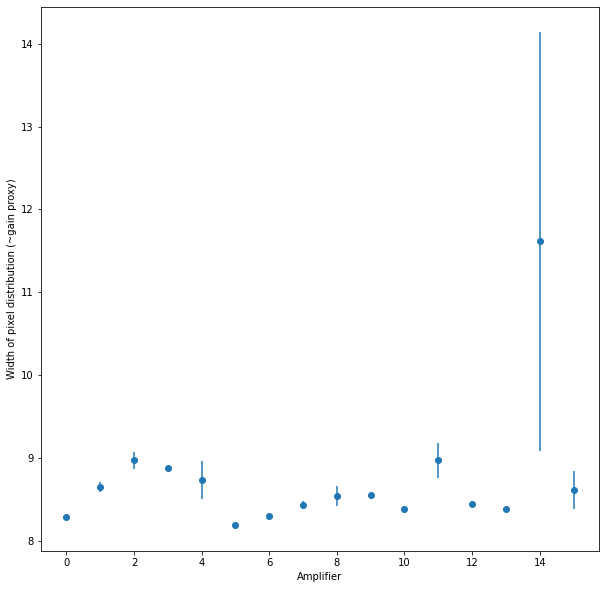

In [11]:
fig = pylab.figure(figsize=(10,10))
nedge=4
meanarr=[]
stdarr=[]
for i, j in ( list(itertools.product( range(4), repeat=2 )) ):
    subsec = diff[i+nedge:-nedge:4,j+nedge:-nedge:4].flatten()
    meanarr.append( numpy.std( subsec ) )
    stdarr.append( numpy.std(bootstrap( subsec, bootfunc=numpy.std ))  )

#pylab.errorbar( x=numpy.arange(len(meanarr)),  y=meanarr, yerr=stdarr/numpy.sqrt(len(meanarr)) )
print(meanarr)
print(stdarr)
pylab.errorbar( x=numpy.arange(len(meanarr)),  y=meanarr, yerr=stdarr, fmt="o" )
pylab.ylabel("Width of pixel distribution (~gain proxy)")
pylab.xlabel("Amplifier")

チャンネルごとにゲインか readout ノイズが違う（あたりまえかな）

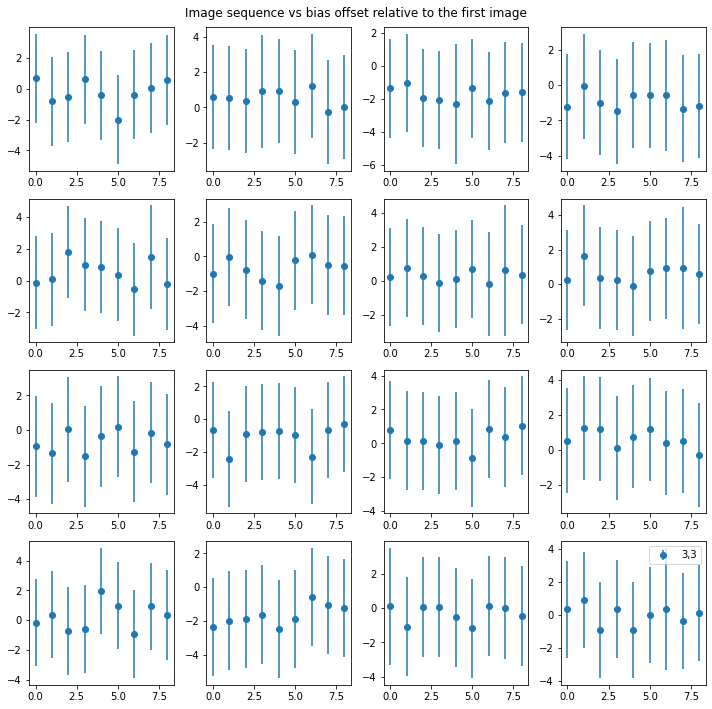

In [12]:
figs, axs = pylab.subplots(4, 4, figsize=(10,10))

nedge
for i, j in ( list(itertools.product( range(4), repeat=2 )) ):
    meanarr = []
    stdarr = []
    for k in range(len(fh[0].data)-1):
        diff = fh[0].data[0] - fh[0].data[k+1]
        amp = diff[i+nedge:-nedge:4,j+nedge:-nedge:4].flatten()
        meanarr.append(numpy.mean(amp))
        stdarr.append(numpy.std(amp))        
    axs[i][j].errorbar( range(len(stdarr)), meanarr, stdarr/numpy.sqrt(stdarr), label=f"{i},{j}", fmt="o" )

pylab.legend(ncol=2)
pylab.suptitle("Image sequence vs bias offset relative to the first image")
pylab.tight_layout()



各チャンネルごとに最初のフレームとの引き算の平均値がどれだけずれているかを書いた．数カウントレベルで揺れている．

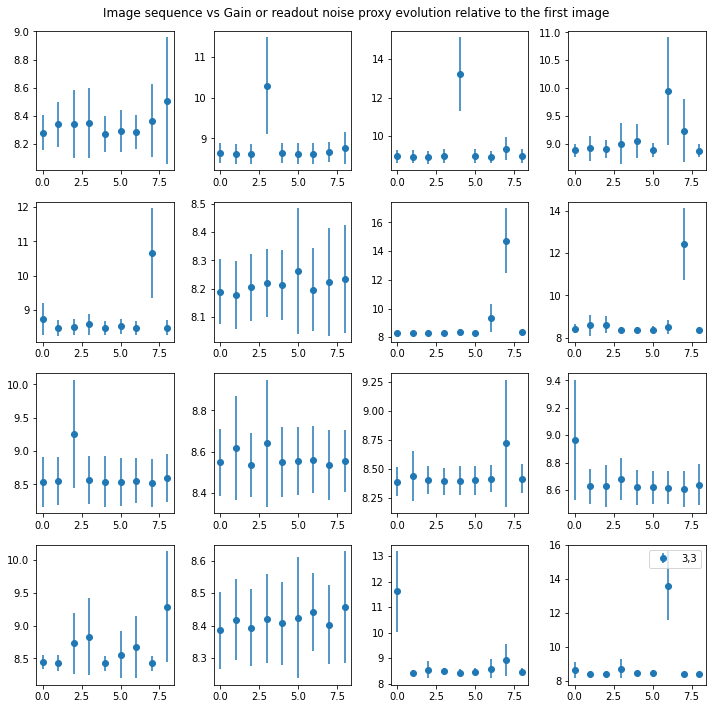

In [13]:
figs, axs = pylab.subplots(4, 4, figsize=(10,10))

for i, j in ( list(itertools.product( range(4), repeat=2 )) ):
    meanarr = []
    stdarr = []
    for k in range(len(fh[0].data)-1):
        diff = fh[0].data[0] - fh[0].data[k+1]
        amp = diff[i+nedge:-nedge:4,j+nedge:-nedge:4].flatten()
        meanarr.append(numpy.std(amp))
        stdarr.append(numpy.std(bootstrap( amp, bootfunc=numpy.std )))        
    axs[i][j].errorbar( range(len(stdarr)), meanarr, stdarr/numpy.sqrt(stdarr), label=f"{i},{j}", fmt="o" )

pylab.legend(ncol=2)
pylab.suptitle("Image sequence vs Gain or readout noise proxy evolution relative to the first image")
pylab.tight_layout()



各チャンネルごとにピクセルヒストグラムの分散（ゲインのプロキシー？or readout noise）がどう変化しているかを調べた．なんか飛ぶのは cosmic ray とかのせいかな？？？
系統的な変な変動が見えるような気もする．

上部の refernce pixel っぽいのを引いてみる
-----
NAXIS1  =                 2220 / size of the axis1                              
NAXIS2  =                 1360 / size of the axis2    
EFP-MIN1=                   61 / Start X pos. of effective area (pix)           
EFP-MIN2=                    1 / Start Y pos. of effective area (pix)           
EFP-RNG1=                 2160 / X range of effective area (pix)                
EFP-RNG2=                 1280 / Y range of effective area (pix)      

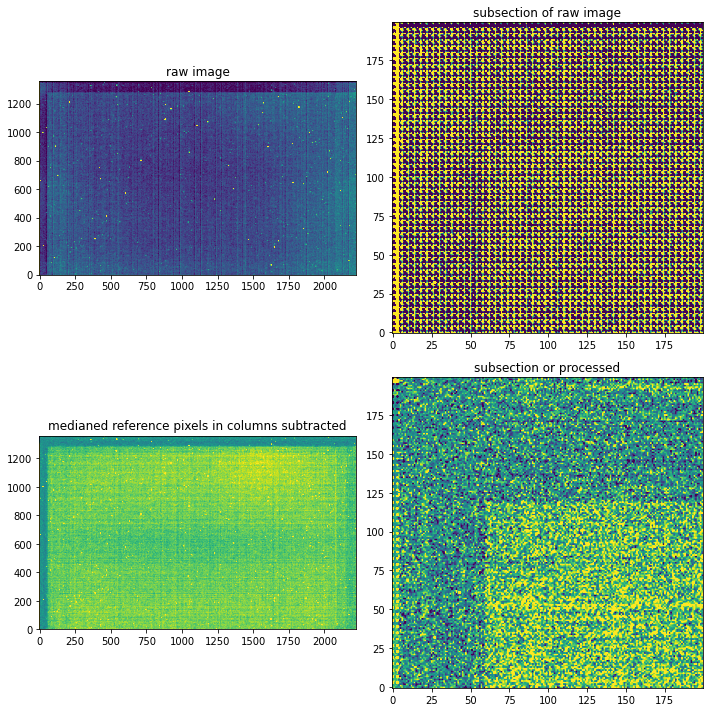

In [14]:
def refsub( img, header=fh[0].header, rowcol=True ):
    new = numpy.zeros( (header["NAXIS2"], header["NAXIS1"] ), numpy.float64 )
    yref = header["NAXIS2"] - header["EFP-RNG2"]
    ntrim = 2

    for i, j in  list(itertools.product( range(4), repeat=2 )):
        if rowcol:
            new[i::4,j::4] = img[i::4,j::4] - numpy.tile(
                numpy.median(img[i::4,j::4][:,ntrim:int((header["EFP-MIN1"]-1)/4)-ntrim], axis=1),
                (int(header["NAXIS1"]/4),1)
            ).T
        else:
            new[i::4,j::4] = img[i::4,j::4]      # Only columns subtraction if commented out this line
        new[i::4,j::4] = new[i::4,j::4] - numpy.median(new[i::4,j::4][-int(yref/4-ntrim):-ntrim,:], axis=0)
    return new

figs, axs = pylab.subplots(2, 2, figsize=(10,10))

s = mad_std(img)
m = numpy.mean(img)
new = refsub(img, fh[0].header )
opt = {
    "vmin":s*-0.3,
    "vmax":s*0.3,
    "origin":"lower"
}

axs[0][0].imshow( img-m, **opt )
axs[0][0].set_title("raw image")
axs[0][1].imshow( img[-200:,:200]-m, **opt )
axs[0][1].set_title("subsection of raw image")
axs[1][0].imshow( new, **opt )
axs[1][0].set_title("medianed reference pixels in columns subtracted")
axs[1][1].imshow( new[-200:,:200], **opt )
axs[1][1].set_title("subsection or processed")
pylab.tight_layout()

パターンなくなるじゃん．同じ解析をしてみる．

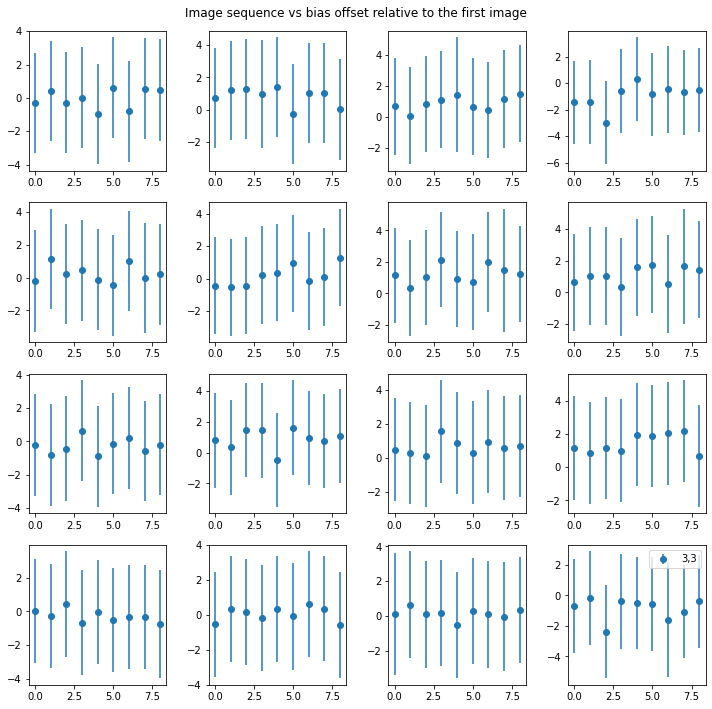

In [15]:
figs, axs = pylab.subplots(4, 4, figsize=(10,10))

nedge
for i, j in ( list(itertools.product( range(4), repeat=2 )) ):
    meanarr = []
    stdarr = []
    for k in range(len(fh[0].data)-1):
        diff = refsub(fh[0].data[0]) - refsub(fh[0].data[k+1])
        amp = diff[i+nedge:-nedge:4,j+nedge:-nedge:4].flatten()
        meanarr.append(numpy.mean(amp))
        stdarr.append(numpy.std(amp))        
    axs[i][j].errorbar( range(len(stdarr)), meanarr, stdarr/numpy.sqrt(stdarr), label=f"{i},{j}", fmt="o" )

pylab.legend(ncol=2)
pylab.suptitle("Image sequence vs bias offset relative to the first image")
pylab.tight_layout()


In [ ]:
figs, axs = pylab.subplots(4, 4, figsize=(10,10))

for i, j in ( list(itertools.product( range(4), repeat=2 )) ):
    meanarr = []
    stdarr = []
    for k in range(len(fh[0].data)-1):
        diff = refsub(fh[0].data[0]) - refsub(fh[0].data[k+1])
        amp = diff[i+nedge:-nedge:4,j+nedge:-nedge:4].flatten()
        meanarr.append(numpy.std(amp))
        stdarr.append(numpy.std(bootstrap( amp, bootfunc=numpy.std )))        
    axs[i][j].errorbar( range(len(stdarr)), meanarr, stdarr/numpy.sqrt(stdarr), label=f"{i},{j}", fmt="o" )

pylab.legend(ncol=2)
pylab.suptitle("Image sequence vs Gain or readout noise proxy evolution relative to the first image")
pylab.tight_layout()

Median stacked dark を作る

In [ ]:
figs, axs = pylab.subplots(2, 1, figsize=(10,10))

stacked = numpy.median([ refsub(fh[0].data[i], fh[0].header ) for i in range(10) ],axis=0)
axs[0].imshow(stacked, vmin=-stacked.std()*0.1, vmax=stacked.std()*0.1, origin="lower")
axs[1].imshow(stacked[-200:,:200], vmin=-stacked.std()*0.1, vmax=stacked.std()*0.1, origin="lower")

In [ ]:
# -yref:-ntrim

ntrim = 5
yref = fh[0].header["NAXIS2"] - fh[0].header["EFP-RNG2"]



#pylab.plot(numpy.median(stacked[-20:-5,:],axis=0),label="X")
pylab.plot(numpy.median(stacked[-yref:-ntrim,:],axis=0),label="X")
pylab.plot(numpy.median(stacked[:,ntrim:int((fh[0].header["EFP-MIN1"]-1)/4)],axis=1),label="Y")
pylab.legend()

In [ ]:
pylab.plot(numpy.mean(img[::4,::4][-50:,10:11],axis=1),label="Y")
pylab.plot(numpy.mean(img[::4,::4][10:11,:50]+5,axis=0),label="X")
pylab.ylim( img[::4,::4][100:,:].mean()-0.1*img[100:,:].std(), img[::4,::4][100:,:].mean()+0.1*img[100:,:].std() )
pylab.legend()

標準偏差 --- dark の時間変化の空間分布 rowcol=True

In [ ]:
figs, axs = pylab.subplots(2, 1, figsize=(10,10))

stacked = numpy.std([ refsub(fh[0].data[i], fh[0].header, rowcol=True ) for i in range(10) ],axis=0)
opt = {
    "vmin": -stacked.std()*0.01+numpy.median(stacked),
    "vmax": stacked.std()*0.01+numpy.median(stacked),
    "origin": "lower"
}
axs[0].imshow(stacked, **opt)
axs[1].imshow(stacked[-200:,:200], **opt )

標準偏差 --- dark の時間変化の空間分布 rowcol=False

In [ ]:
figs, axs = pylab.subplots(2, 1, figsize=(10,10))

stacked = numpy.std([ refsub(fh[0].data[i], fh[0].header, rowcol=False ) for i in range(10) ],axis=0)
opt = {
    "vmin": -stacked.std()*0.01+numpy.median(stacked),
    "vmax": stacked.std()*0.01+numpy.median(stacked),
    "origin": "lower"
}
axs[0].imshow(stacked, **opt)
axs[1].imshow(stacked[-200:,:200], **opt )

In [ ]:
figs, axs = pylab.subplots(1, 2, figsize=(20,10))
# EFP-RNG2
new = refsub(fh[0].data[0], fh[0].header, rowcol=False )
for ax, img in zip(axs,[fh[0].data[0], new]):
    x = img[1:fh[0].header["EFP-RNG2"],fh[0].header["EFP-MIN1"]:fh[0].header["EFP-RNG2"]].flatten()
    y = img[:fh[0].header["EFP-RNG2"]-1,fh[0].header["EFP-MIN1"]:fh[0].header["EFP-RNG2"]].flatten()
    ax.plot( x-x.mean(), y-y.mean(), ".", alpha=0.1)
    ax.set_xlim(-100,100)
    ax.set_ylim(-100,100)    

In [ ]:
figs, axs = pylab.subplots(1, 2, figsize=(20,10))
# EFP-RNG2
new = refsub(fh[0].data[0], fh[0].header, rowcol=True )
for ax, img in zip(axs,[fh[0].data[0], new]):
    x = img[1:fh[0].header["EFP-RNG2"],fh[0].header["EFP-MIN1"]:fh[0].header["EFP-RNG2"]].flatten()
    y = img[:fh[0].header["EFP-RNG2"]-1,fh[0].header["EFP-MIN1"]:fh[0].header["EFP-RNG2"]].flatten()
    ax.plot( x-x.mean(), y-y.mean(), ".", alpha=0.1)
    ax.set_xlim(-100,100)
    ax.set_ylim(-100,100)    

In [ ]:
figs, axs = pylab.subplots(1, 2, figsize=(20,10))
# EFP-RNG2
new = refsub(fh[0].data[0], fh[0].header, rowcol=False )
for ax, img in zip(axs,[fh[0].data[0], new]):
    x = img[:fh[0].header["EFP-RNG2"],fh[0].header["EFP-MIN1"]+1:fh[0].header["EFP-RNG2"]].flatten()
    y = img[:fh[0].header["EFP-RNG2"],fh[0].header["EFP-MIN1"]:fh[0].header["EFP-RNG2"]-1].flatten()
    print(mad_std(x), mad_std(y))    
    ax.plot( x-x.mean(), y-y.mean(), ".", alpha=0.1)
    ax.set_xlim(-100,100)
    ax.set_ylim(-100,100)    

In [ ]:
figs, axs = pylab.subplots(1, 2, figsize=(20,10))
# EFP-RNG2
new = refsub(fh[0].data[0], fh[0].header, rowcol=True )
for ax, img in zip(axs,[fh[0].data[0], new]):
    x = img[:fh[0].header["EFP-RNG2"],fh[0].header["EFP-MIN1"]+1:fh[0].header["EFP-RNG2"]].flatten()
    y = img[:fh[0].header["EFP-RNG2"],fh[0].header["EFP-MIN1"]:fh[0].header["EFP-RNG2"]-1].flatten()
    print(mad_std(x), mad_std(y))
    ax.plot( x-x.mean(), y-y.mean(), ".", alpha=0.1)
    ax.set_xlim(-100,100)
    ax.set_ylim(-100,100)    